# APS1070
#### Anomaly Detection - Project 2



Project 2 has two parts: a tutorial component (which will be covered in labs) and an exercises component (to be completed as homework, individually). Overall, this project is worth 12.5% of your final grade. Completing the tutorial section is worth 2.5 marks. The exercises section will be graded out of the remaining 10 marks.


Please fill out the following:


*   Your **name**: YixiaoHong
*   Your **student number**: 1001311145



## Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

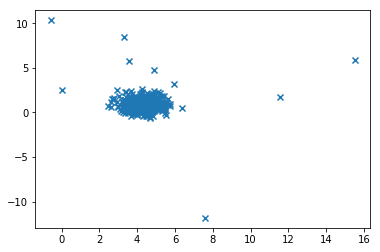

In [0]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)

X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)

X = np.vstack([X,X_append])

y_true = np.hstack([y_true, [1 for _ in y_true_append]])

X = X[:, ::-1] # flip axes for better plotting

plt.scatter(X[:,0],X[:,1],marker="x");


Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulae:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [0]:
def estimateGaussian(X):
    """
     This function provides an estimate of mean and variance 
     of a Gaussian distribution along multiple dimensions
     using X, an N-dimensional vector
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = 1/m *sum_
    
    # compute variance of X
    var = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,var
  
  
mu, sigma = estimateGaussian(X)



Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [0]:
def multivariateGaussian(X, mu, sigma):
    """
    This function computes the probability density function of a multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
  
  
p = multivariateGaussian(X, mu, sigma)

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

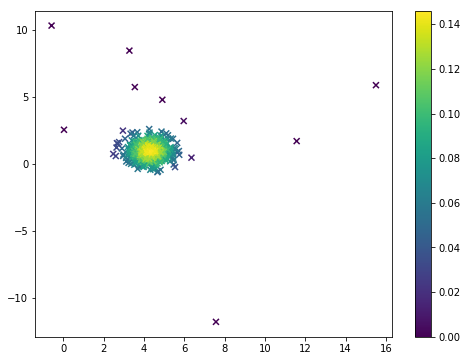

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programatically identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [0]:
#Choose a value for epsilon

epsilon = 0.03

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

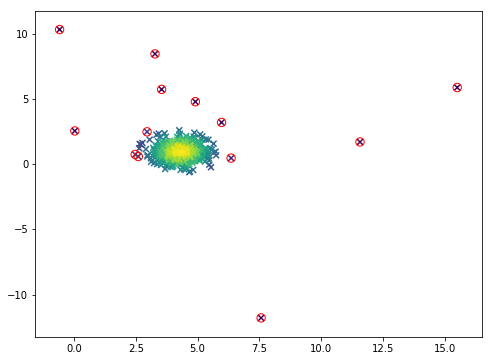

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

How well did your epsilon value do? Play around with different values until you're happy with the plot above. **The epslon value of 0.03 that I choose rehected data which are too far from the cluster center, it did pretty well.**

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the highest value of K for which we get precision of 1.0? __K=10__
* What is the precision for K=4? __1.0__

In [0]:
from sklearn.metrics import precision_score

highestK = 0

for i in range(len(p)):
    print("k=",i+1)
    mn = sorted(p)[i]
    print("mn=",mn)
    sc = precision_score(y_true, p<=mn)
    #print(p<=mn)
    print("precision Score is:", sc)
    if sc == 1.0:
      highestK = i+1
    else:
      break
      
print("The highest precision score of K which we get precision of 1.0 is K=",highestK)
        
mn = sorted(p)[3]
print("===>The precision of K=4 is:", precision_score(y_true, p<=mn))        



k= 1
mn= 1.2623338074896085e-34
precision Score is: 1.0
k= 2
mn= 4.230733234412769e-32
precision Score is: 1.0
k= 3
mn= 4.1553788011719993e-22
precision Score is: 1.0
k= 4
mn= 7.824881490919078e-14
precision Score is: 1.0
k= 5
mn= 1.995682160401512e-11
precision Score is: 1.0
k= 6
mn= 3.373491415874567e-06
precision Score is: 1.0
k= 7
mn= 1.3829001337937193e-05
precision Score is: 1.0
k= 8
mn= 0.00038375614794800423
precision Score is: 1.0
k= 9
mn= 0.004746481681385717
precision Score is: 1.0
k= 10
mn= 0.014143197889903505
precision Score is: 1.0
k= 11
mn= 0.02272163838953631
precision Score is: 0.9090909090909091
The highest precision score of K which we get precision of 1.0 is K= 10
===>The precision of K=4 is: 1.0


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is because we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to Mixture of Gaussian models. Take a look at the following dataset:

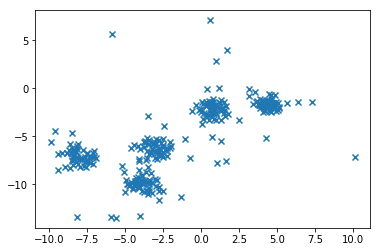

In [0]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below? _**1**__
* k=10? __**0.9**_
* k=100? __**0.13**_

==>Precision for K = 1 is: 1.0
==>Precision for K = 10 is: 0.9
==>Precision for K = 100 is: 0.13


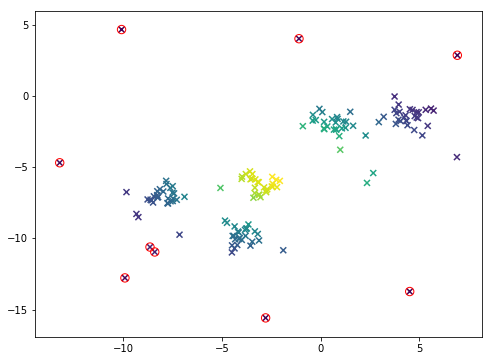

In [0]:
mu, sigma = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);


for i in range(len(p)):
    K=i+1
    mn_test = sorted(p)[i]
    sc = precision_score(y_test, p<=mn_test)
   
    if K == 1:
      print("==>Precision for K =", K, "is:",sc)
    elif K == 10:
      print("==>Precision for K =", K, "is:",sc)
    elif K == 100:
      print("==>Precision for K =", K, "is:",sc)
    elif K>100:
      break

Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [0]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.predict_proba()` to get the probability of each data point being in any of the five clusters:

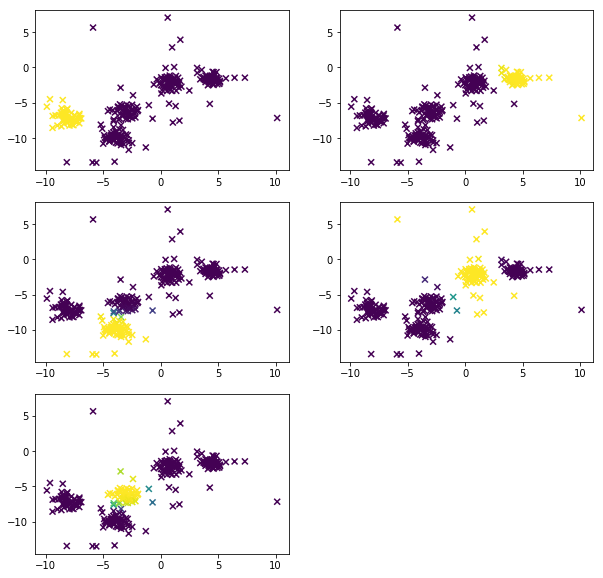

In [0]:
#plt.subplots(3,2,figsize=(8,6))
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

Use the following formula to calculate the probability of each point, and set it to `p`:

$$p(x) = 1 - \bigg( \prod_{i=1}^{k} 1 - p(x \in k) \bigg)$$

This formula returns the probability that the datapoint was produced at random by _any_ of the Gaussians we fit. Hence, we want to filter out anything without a very high probability of this.

In the cell below, calculate these values and then compute precision@k for k=1, 10, and 100.

* Is this model better or worse performing than the previous? _**Better**__
* Why might that be? __**Because "score_samples" gives a score based on how likely a point is to have been generated by any cluster while the previous method trying to fit the data into one gaussian**__

===>Results by using probability function p(x)
==>Precision for K = 1 is: 0.0
==>Precision for K = 10 is: 0.4
==>Precision for K = 100 is: 0.07
===>Results by using score_samples
For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000


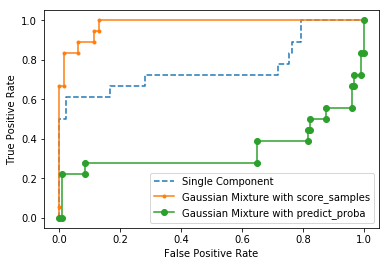

In [0]:
#The following code calculate the precision using the predict_proba p(x)
ps = gm.predict_proba(X_test)

#Calculate the probability of each point using above formula
newp = 1 - np.prod(1-ps, axis=1)

print("===>Results by using probability function p(x)")

for i in range(len(newp)):
    K=i+1
    mn = sorted(newp)[i]
    sc = precision_score(y_test, newp<=mn)
    if K == 1:
      print("==>Precision for K =", K, "is:",sc)
    elif K == 10:
      print("==>Precision for K =", K, "is:",sc)
    elif K == 100:
      print("==>Precision for K =", K, "is:",sc)
    elif K>100:
      break

print("===>Results by using score_samples")      
      
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

p_gm = gm.score_samples(X_test) #score_samples will compute the weighted log probabilities for each sample

for i in [1, 10, 100]: #Let's look at 3 different k values
  mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
  precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
  recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
  print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
fpr_probg, tpr_probg, _ = roc_curve(y_test, 1-newp)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture with score_samples')
pyplot.plot(fpr_probg, tpr_probg, marker='o', label='Gaussian Mixture with predict_proba')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
  

Although our MoG model doesn't perfectly identify all the outliers, (it performs way better than our previous model)**ignore**, again without any label information to help it along!

Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [0]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)

--2019-10-23 06:49:39--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2019-10-23 06:49:39--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle.8’

simpsons.pickle.8   100%[===================>]  25.46K  --.-KB/s    in 0.007s  

2019-10-23 06:49:39 (3.76 MB/s) - ‘simpsons.pickle.8’ saved [26076/26076]



With `plt.hist`, plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating? _**7.1**_
* What is the range of ratings? _**(4.0,9.3)**_

minRate= 4.0 maxRate= 9.3


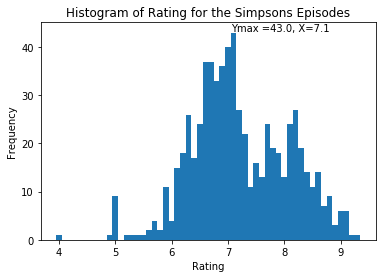

In [0]:
import pandas as pd

#create a dataframe which collects the rating for each episode
dataframe = pd.DataFrame(columns=["season","episode","rating"])

#loop through the data dictionary and store them into the dataframe
for seasonNum in simpsons:
  for episodeName in simpsons[seasonNum]:
    dataframe = dataframe.append({"season":seasonNum,"episode":episodeName,"rating":simpsons[seasonNum][episodeName]},ignore_index=True)

#find the minimum rating and maximum rating among all ratings
minRate = min(dataframe["rating"])
maxRate = max(dataframe["rating"])
print("minRate=",minRate,"maxRate=",maxRate)

#find the range of the histogram plotting
min_binVal = minRate - 0.05
max_binVal = maxRate + 0.05

#find the bins of the histogram plotting with 0.1 for each increment since all the rating has ani increment of 0.1
num_bins = int((maxRate-minRate)/0.1+1)

#do the histogram plot 
y, x, _  = plt.hist(x=dataframe["rating"], bins=num_bins,range=(min_binVal,max_binVal))
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Rating for the Simpsons Episodes')

#print(x,y)

# Compute the max value (plt.hist returns the x and y positions of the bars)
ymax = y.max()
idx = np.where(y == ymax)[0][0]
xval = x[idx]

# Annotate the highest value
text = 'Ymax =' + str(ymax) + ', X=' + "{:.1f}".format(xval)
plt.gca().text(xval, ymax, text, ha='left', va='bottom')

plt.show()


Next, use `sklearn.mixture.GaussianMixture` to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? _**6.77 and 8.18**_
* What about the standard deviations? _**0.597 and 0.474**_

In [0]:
array = dataframe["rating"].values
array = array.reshape(-1, 1)

#performe Guassian Mixture fitting with 2 clusters
gm_simpsons = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0, )
model = gm_simpsons.fit(array)
m = model.means_
cov = model.covariances_

print("===>The means for the two Gaussians are:",m)
print("===>The standard deviation of the two Gaussians are:\n", np.sqrt(cov))




===>The means for the two Gaussians are: [[6.7734211 ]
 [8.17942889]]
===>The standard deviation of the two Gaussians are:
 [[[0.59689303]]

 [[0.4741226 ]]]


Finally, using the `GaussianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, count the number of episodes predicted to be in the "good" distribution per season, and plot using `plt.plot`.

* Where is the notable drop-off point? _**season 10**_
* When is the first season with 0 good episodes? _**season 15**_

    season  Sum of Good Episodes
0        1                     9
1        2                    18
2        3                    24
3        4                    21
4        5                    21
5        6                    24
6        7                    24
7        8                    24
8        9                    20
9       10                    10
10      11                     4
11      12                     5
12      13                     4
13      14                     1
14      15                     0
15      16                     0
16      17                     0
17      18                     1
18      19                     1
19      20                     0
20      21                     0
21      22                     0
22      23                     2
23      24                     0
24      25                     1
25      26                     1
26      27                     1
27      28                     0
28      29                     0
29      30

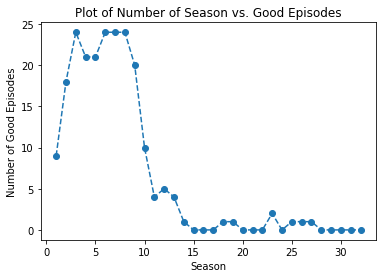

In [0]:
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))

predictResults = gm_simpsons.predict(array)
predictResultArray = np.array(predictResults)
predictResultArray = predictResultArray.reshape(-1, 1)

#Append the new predicted class array to the dataframe
pd = pd.concat([dataframe, pd.DataFrame(predictResultArray,columns=["predictedClass"])], axis=1)

result = pd[["season","predictedClass"]].groupby(["season"],as_index = False).sum().rename(columns={"season":"season","predictedClass": "Sum of Good Episodes"})

print(result)

x = np.array(result["season"])
y = np.array(result["Sum of Good Episodes"])

plt.plot(x,y,linestyle = '--', marker='o')
plt.xlabel('Season')
plt.ylabel('Number of Good Episodes')
plt.title('Plot of Number of Season vs. Good Episodes')
plt.show()






## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset using Pandas' `read_csv` function. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[1] __**284807**___
* What features in the dataset are present aside from the 28 main features?[1] __**Time, Amount**___
* Why do you think the main features are given to us in this way?[1] ___**The features are principal components obtained with Primary Component Analysis (PCA) so that the variances are maximized**__
* Which column contains the targets? Can you figure out what the values correspond to?[1] __**in column "Class", 1 means fraud, 0 means non-fraud**___

In [0]:
pip install wget

In [0]:
import wget
wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (7).gz'

In [0]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
dataset = pd.read_csv("creditcard.csv")
print(dataset.shape)
print(dataset.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[1] __**0.17% for positive class (fraud) and 99.83% for negative class (non-fraud)**___
* Why might this pose a problem with methods we have looked at so far?[1] __**The Number of samples in negative class (non-fraud) is much more than the number of samples in positive (fraud) class, which might cause the classifier unable to distinguish the two classes and the fraud class might be simply treated as noises**___



In [0]:
numofFraud = sum(dataset["Class"] == 1)
numofNotFred = dataset.shape[0] - numofFraud
print("Class:Fraud% = ","{0:.2f}%".format(numofFraud/dataset.shape[0] * 100))
print("Class:Non-Fraud% = ","{0:.2f}%".format(numofNotFred/dataset.shape[0] * 100))

Class:Fraud% =  0.17%
Class:Non-Fraud% =  99.83%


Next, split the dataset into a training and testing set using sklearn's `train_test_split` function. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in these exercises we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this.[1] __**mean = 0.0004297, standard deviation = 0.604829**___

Use the code below to set up a Gaussian object for V24.

In [0]:
from scipy import stats
feature=dataset.iloc[:,1:29].copy()
target=dataset.iloc[:,-1].copy()

#split the test into 1/3
X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=1/3,random_state=0)
X_train_std = X_train["V24"].std()
X_train_mean = X_train["V24"].mean()

print("Mean = ",X_train_mean)
print("Standard Deviation =", X_train_std)

#The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation.
norm = stats.norm(loc=X_train_mean, scale=X_train_std)

Mean =  0.00042967016116414686
Standard Deviation = 0.6048294388274841


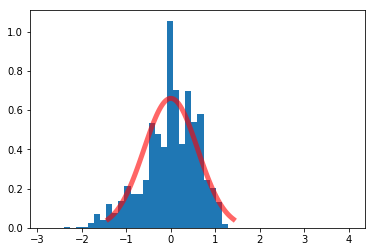

In [0]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

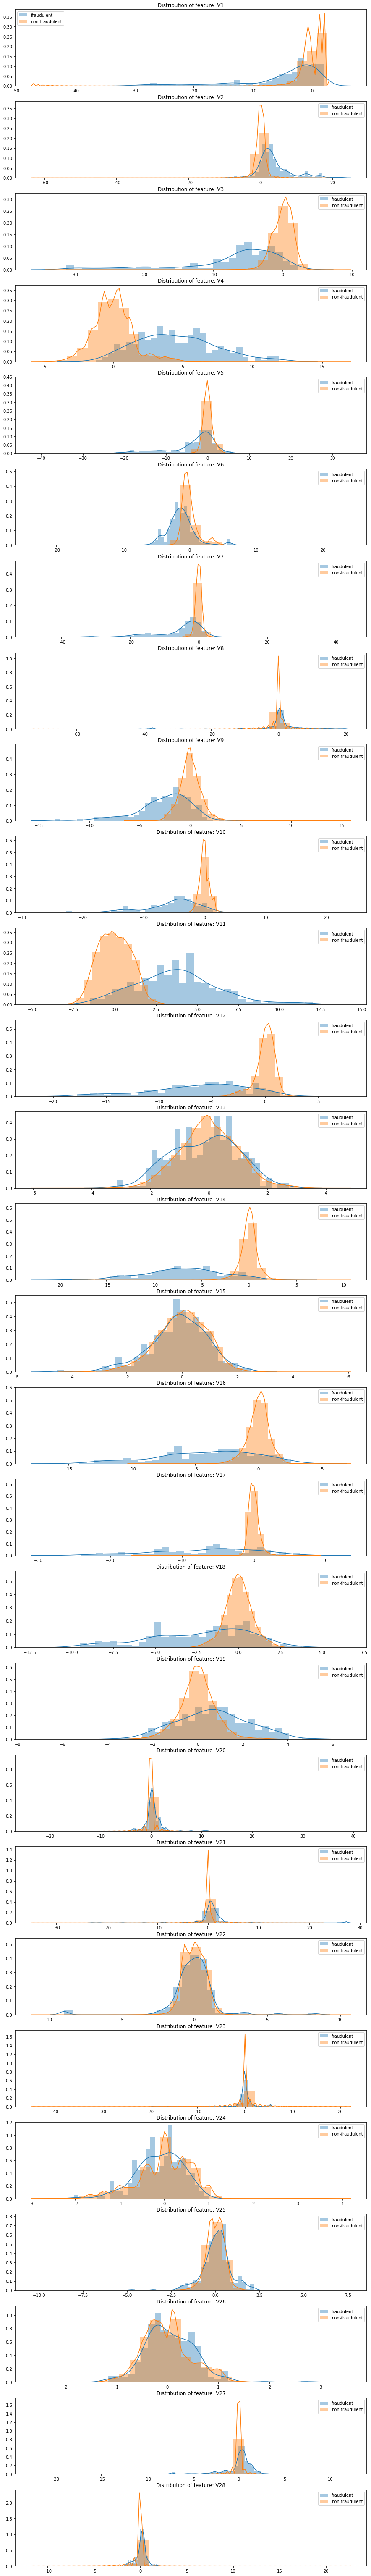

In [0]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in dataset.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Build an outlier detection model using a Mixture of Gaussians using a subset of features of your choice (pick a few) and a number of mixture components. Report both the precision@k and recall@k for k=1, 10 and 100 (on test data). Repeat this model creation process at least 4 more times, each time selecting different parameters (features selected, number of mixture components), and reporting the precision and recall as above. Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best? [3]

In [0]:
# From observation the distribution diagram above, 
# I find the following features have more seperate distribution between 
# class of fraudulent and non-fraudulent. 
# Feature:4,11,12,14,16,17,18,19
# Would like to test several combinitions from the above features since they have
# more potential to achieve a higher percision score

# try several combinition of  selecting 2 feature per test
subTrainSet1 = X_train[["V4","V11"]]
subTrainSet2 = X_train[["V12","V14"]]
subTrainSet3 = X_train[["V16","V17"]]
subTrainSet4 = X_train[["V18","V19"]]

subTestSet1 = X_test[["V4","V11"]]
subTestSet2 = X_test[["V12","V14"]]
subTestSet3 = X_test[["V16","V17"]]
subTestSet4 = X_test[["V18","V19"]]

# try several combinition of  selecting 4 feature per test
subTrainSet5 = X_train[["V4","V11","V12","V14"]]
subTrainSet6 = X_train[["V16","V17","V18","V19"]]

subTestSet5 = X_test[["V4","V11","V12","V14"]]
subTestSet6 = X_test[["V16","V17","V18","V19"]]


#For comparision, this time choose some features other than the above ones, expecting worse results 
subTrainSet7 = X_train[["V1","V2"]]
subTrainSet8 = X_train[["V27","V28"]]

subTestSet7 = X_test[["V1","V2"]]
subTestSet8 = X_test[["V27","V28"]]

subTrainSet9 = X_train[["V1","V2","V27","V28"]]
subTestSet9 = X_test[["V1","V2","V27","V28"]]


#make a list of dictionary to prepare for the loop
subTrainDict = {0:subTrainSet1,1:subTrainSet2,2:subTrainSet3,3:subTrainSet4,4:subTrainSet5,5:subTrainSet6,6:subTrainSet7,7:subTrainSet8,8:subTrainSet9}
subTestDict = {0:subTestSet1,1:subTestSet2,2:subTestSet3,3:subTestSet4,4:subTestSet5,5:subTestSet6,6:subTestSet7,7:subTestSet8,8:subTestSet9}


#Prepare a datatable for record
resultsDF = pd.DataFrame(columns=["SubSetNumber","Selected Features","n_component","Precision@K=1","Recall@K=1","Precision@K=10","Recall@K=10","Precision@K=100","Recall@K=100","ExpectedResult"])

#performe the loop
for j in range(9):
  for c in range(1,5):
    #print("=================================================================================================")
    print("=====>Train Gaussian Mixture for subset #", j+1, " with n_component = ", c)
    #print("========> With features of:",str(subTrainDict[j].columns)[7:-18],"with component of:",c)
    gm = GaussianMixture(n_components =c, covariance_type = 'full', random_state=0)
    gm.fit(subTrainDict[j])

    #print("=====>Result:")
    #This part outputs the precision and recall on the test set
    p_gm = gm.score_samples(subTestDict[j]) #score_samples will compute the weighted log probabilities for each sample

    
    recordList = []
    for i in [1, 10, 100]: #Let's look at 3 different k values
      recordDic = dict()
      mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
      precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
      recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
      pre = '%.3f' % precision
      rec = '%.3f' % recall
      #print('For a k of ',i,' the precision is ',pre ,' and the recall is ',rec ) #We print precision and recall three times
      recordDic["precision"]=pre
      recordDic["recall"]=rec
      recordList.append(recordDic)
      
    
    expect = lambda x : "Good" if (x<6) else "Bad"
    resultsDF = resultsDF.append({"SubSetNumber":j,
                           "Selected Features":str(subTrainDict[j].columns)[7:-18],
                           "n_component":c,
                           "Precision@K=1":recordList[0]["precision"],
                           "Recall@K=1":recordList[0]["recall"],
                           "Precision@K=10":recordList[1]["precision"],
                           "Recall@K=10":recordList[1]["recall"],
                           "Precision@K=100":recordList[2]["precision"],
                           "Recall@K=100":recordList[2]["recall"],
                           "ExpectedResult":expect(j),
                          }, ignore_index=True)
     

      


=====>Train Gaussian Mixture for subset # 1  with n_component =  1
=====>Train Gaussian Mixture for subset # 1  with n_component =  2
=====>Train Gaussian Mixture for subset # 1  with n_component =  3
=====>Train Gaussian Mixture for subset # 1  with n_component =  4
=====>Train Gaussian Mixture for subset # 2  with n_component =  1
=====>Train Gaussian Mixture for subset # 2  with n_component =  2
=====>Train Gaussian Mixture for subset # 2  with n_component =  3
=====>Train Gaussian Mixture for subset # 2  with n_component =  4
=====>Train Gaussian Mixture for subset # 3  with n_component =  1
=====>Train Gaussian Mixture for subset # 3  with n_component =  2
=====>Train Gaussian Mixture for subset # 3  with n_component =  3
=====>Train Gaussian Mixture for subset # 3  with n_component =  4
=====>Train Gaussian Mixture for subset # 4  with n_component =  1
=====>Train Gaussian Mixture for subset # 4  with n_component =  2
=====>Train Gaussian Mixture for subset # 4  with n_component 

In [0]:
from IPython.display import display

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
  
resultsDF.style.apply(highlight_max)

display(resultsDF)

,SubSetNumber,Selected Features,n_component,Precision@K=1,Recall@K=1,Precision@K=10,Recall@K=10,Precision@K=100,Recall@K=100,ExpectedResult
0,0,"'V4', 'V11'",1,1.000,0.006,0.900,0.055,0.620,0.378,Good
1,0,"'V4', 'V11'",2,1.000,0.006,1.000,0.061,0.650,0.396,Good
2,0,"'V4', 'V11'",3,1.000,0.006,1.000,0.061,0.670,0.409,Good
3,0,"'V4', 'V11'",4,0.000,0.000,0.700,0.043,0.580,0.354,Good
4,1,"'V12', 'V14'",1,1.000,0.006,1.000,0.061,0.840,0.512,Good
5,1,"'V12', 'V14'",2,1.000,0.006,1.000,0.061,0.790,0.482,Good
6,1,"'V12', 'V14'",3,1.000,0.006,1.000,0.061,0.740,0.451,Good
7,1,"'V12', 'V14'",4,1.000,0.006,1.000,0.061,0.680,0.415,Good
8,2,"'V16', 'V17'",1,1.000,0.006,1.000,0.061,0.770,0.470,Good
9,2,"'V16', 'V17'",2,0.000,0.000,0.900,0.055,0.730,0.445,Good




===========    K vs Precision Plots                     ==============




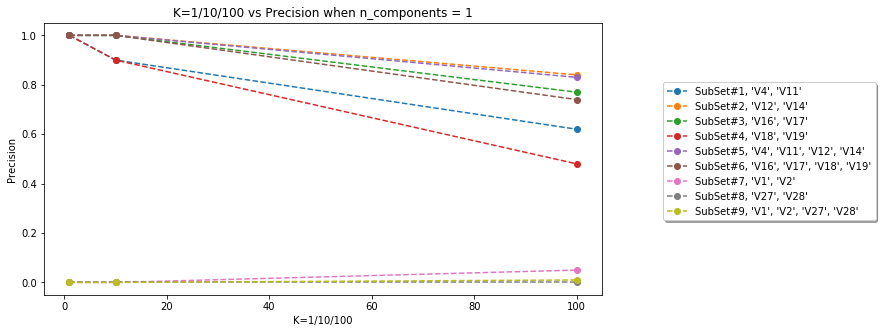

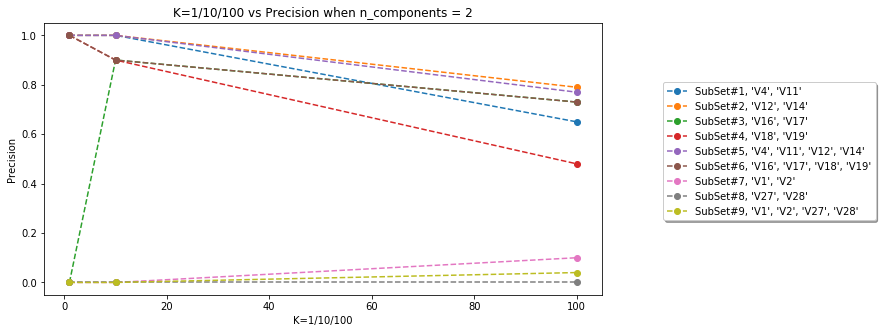

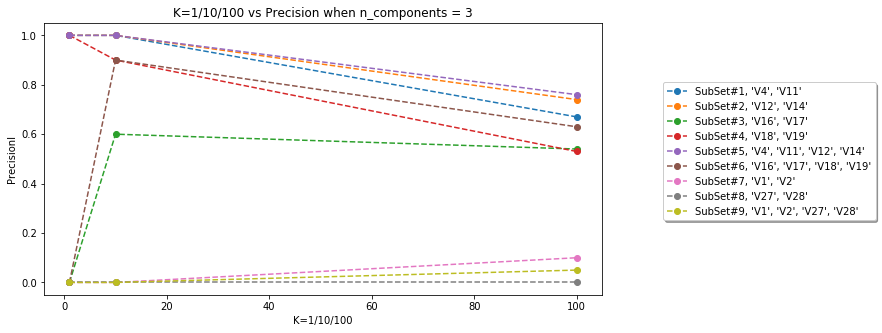

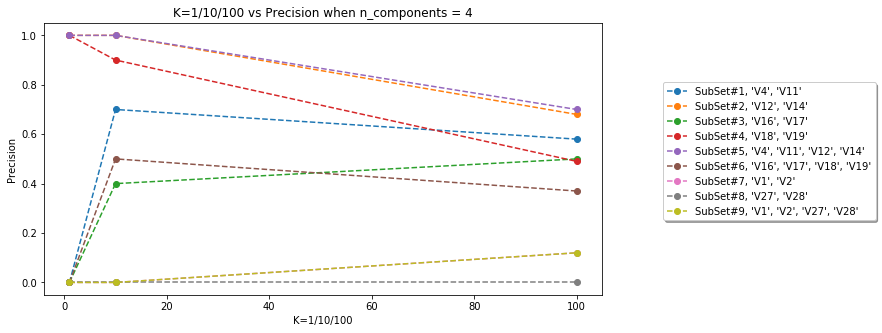

In [0]:
#filter into several datatables for plotting

#k vs p with n =1
k_p_n1 = resultsDF[['Selected Features','Precision@K=1','Precision@K=10','Precision@K=100']][resultsDF["n_component"] == 1]

#k vs p with n =2
k_p_n2 = resultsDF[['Selected Features','Precision@K=1','Precision@K=10','Precision@K=100']][resultsDF["n_component"] == 2]

#k vs p with n =3
k_p_n3 = resultsDF[['Selected Features','Precision@K=1','Precision@K=10','Precision@K=100']][resultsDF["n_component"] == 3]

#k vs p with n =4
k_p_n4 = resultsDF[['Selected Features','Precision@K=1','Precision@K=10','Precision@K=100']][resultsDF["n_component"] == 4]


#k vs r with n =1
k_r_n1 = resultsDF[['Selected Features','Recall@K=1','Recall@K=10','Recall@K=100']][resultsDF["n_component"] == 1]

#k vs r with n =2
k_r_n2 = resultsDF[['Selected Features','Recall@K=1','Recall@K=10','Recall@K=100']][resultsDF["n_component"] == 2]

#k vs r with n =3
k_r_n3 = resultsDF[['Selected Features','Recall@K=1','Recall@K=10','Recall@K=100']][resultsDF["n_component"] == 3]

#k vs r with n =4
k_r_n4 = resultsDF[['Selected Features','Recall@K=1','Recall@K=10','Recall@K=100']][resultsDF["n_component"] == 4]


print("")
print("")
print("======================================================================")
print("===========    K vs Precision Plots                     ==============")
print("======================================================================")
print("")
print("")



#Make plotts for the results n from 1-4:
plt.figure(figsize=(10,5))

features = k_p_n1['Selected Features']
for i in range(len(k_p_n1)):
  yy = k_p_n1[['Precision@K=1','Precision@K=10','Precision@K=100']]
  yy = yy.iloc[ i , : ]
  yy = np.array(yy)
  yy = yy.astype(np.float)
  pyplot.plot(np.array([1,10,100]),yy,linestyle = '--',marker='o',label='SubSet#'+ str(i+1) + ", " + features[4*i])
  
pyplot.xlabel('K=1/10/100')
pyplot.ylabel('Precision')
pyplot.title('K=1/10/100 vs Precision when n_components = 1')
pyplot.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
pyplot.show()


plt.figure(figsize=(10,5))
features = k_p_n2['Selected Features']
for i in range(len(k_p_n2)):
  yy = k_p_n2[['Precision@K=1','Precision@K=10','Precision@K=100']]
  yy = yy.iloc[ i , : ]
  yy = np.array(yy)
  yy = yy.astype(np.float)
  pyplot.plot(np.array([1,10,100]),yy,linestyle = '--',marker='o',label='SubSet#'+ str(i+1) + ", " + features[4*i+1])
pyplot.xlabel('K=1/10/100')
pyplot.ylabel('Precision')
pyplot.title('K=1/10/100 vs Precision when n_components = 2')
pyplot.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
pyplot.show()

plt.figure(figsize=(10,5))
features = k_p_n3['Selected Features']
for i in range(len(k_p_n3)):
  yy = k_p_n3[['Precision@K=1','Precision@K=10','Precision@K=100']]
  yy = yy.iloc[ i , : ]
  yy = np.array(yy)
  yy = yy.astype(np.float)
  pyplot.plot(np.array([1,10,100]),yy,linestyle = '--',marker='o',label='SubSet#'+ str(i+1) + ", " + features[4*i+2])
pyplot.xlabel('K=1/10/100')
pyplot.ylabel('Precisionl')
pyplot.title('K=1/10/100 vs Precision when n_components = 3')
pyplot.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
pyplot.show()

plt.figure(figsize=(10,5))
features = k_p_n4['Selected Features']
for i in range(len(k_p_n4)):
  yy = k_p_n4[['Precision@K=1','Precision@K=10','Precision@K=100']]
  yy = yy.iloc[ i , : ]
  yy = np.array(yy)
  yy = yy.astype(np.float)
  pyplot.plot(np.array([1,10,100]),yy,linestyle = '--',marker='o',label='SubSet#'+ str(i+1) + ", " + features[4*i+3])
pyplot.xlabel('K=1/10/100')
pyplot.ylabel('Precision')
pyplot.title('K=1/10/100 vs Precision when n_components = 4')
pyplot.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
pyplot.show()




===========       K vs Recall Plots                     ==============




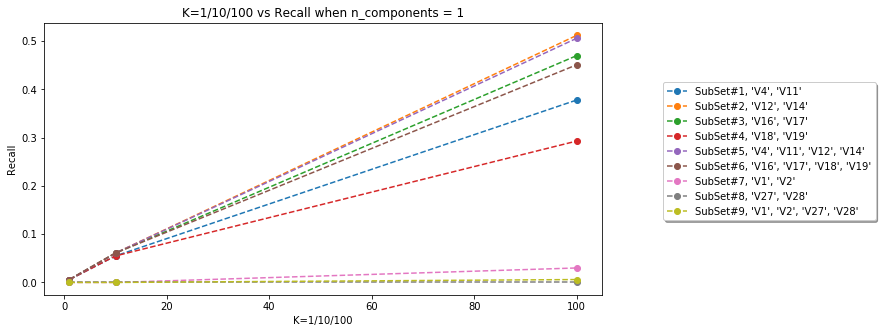

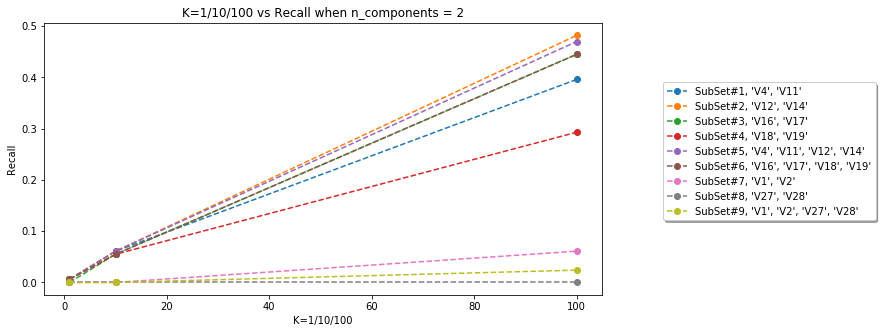

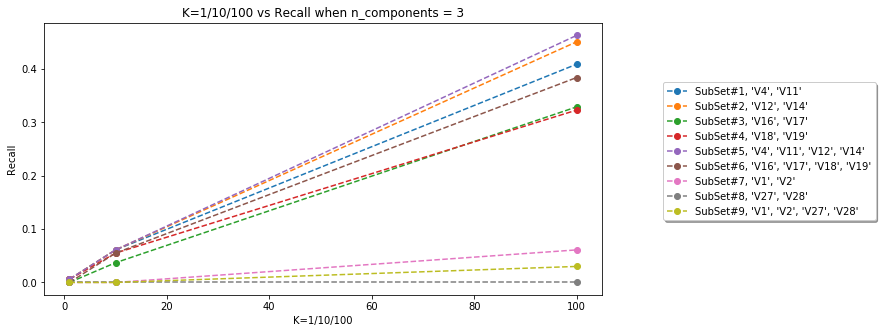

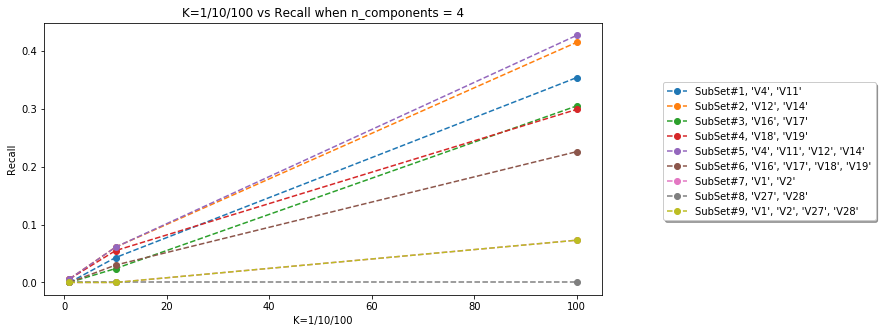

In [0]:
print("")
print("")
print("======================================================================")
print("===========       K vs Recall Plots                     ==============")
print("======================================================================")
print("")
print("")


#Make plotts for the results n from 1-4:
plt.figure(figsize=(10,5))

features = k_r_n1['Selected Features']
for i in range(len(k_r_n1)):
  yy = k_r_n1[['Recall@K=1','Recall@K=10','Recall@K=100']]
  yy = yy.iloc[ i , : ]
  yy = np.array(yy)
  yy = yy.astype(np.float)
  pyplot.plot(np.array([1,10,100]),yy,linestyle = '--',marker='o',label='SubSet#'+ str(i+1) + ", " + features[4*i])
  
pyplot.xlabel('K=1/10/100')
pyplot.ylabel('Recall')
pyplot.title('K=1/10/100 vs Recall when n_components = 1')
pyplot.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
pyplot.show()


plt.figure(figsize=(10,5))
features = k_r_n2['Selected Features']
for i in range(len(k_r_n2)):
  yy = k_r_n2[['Recall@K=1','Recall@K=10','Recall@K=100']]
  yy = yy.iloc[ i , : ]
  yy = np.array(yy)
  yy = yy.astype(np.float)
  pyplot.plot(np.array([1,10,100]),yy,linestyle = '--',marker='o',label='SubSet#'+ str(i+1) + ", " + features[4*i+1])
pyplot.xlabel('K=1/10/100')
pyplot.ylabel('Recall')
pyplot.title('K=1/10/100 vs Recall when n_components = 2')
pyplot.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
pyplot.show()

plt.figure(figsize=(10,5))
features = k_r_n3['Selected Features']
for i in range(len(k_r_n3)):
  yy = k_r_n3[['Recall@K=1','Recall@K=10','Recall@K=100']]
  yy = yy.iloc[ i , : ]
  yy = np.array(yy)
  yy = yy.astype(np.float)
  pyplot.plot(np.array([1,10,100]),yy,linestyle = '--',marker='o',label='SubSet#'+ str(i+1) + ", " + features[4*i+2])
pyplot.xlabel('K=1/10/100')
pyplot.ylabel('Recall')
pyplot.title('K=1/10/100 vs Recall when n_components = 3')
pyplot.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
pyplot.show()

plt.figure(figsize=(10,5))
features = k_r_n4['Selected Features']
for i in range(len(k_r_n4)):
  yy = k_r_n4[['Recall@K=1','Recall@K=10','Recall@K=100']]
  yy = yy.iloc[ i , : ]
  yy = np.array(yy)
  yy = yy.astype(np.float)
  pyplot.plot(np.array([1,10,100]),yy,linestyle = '--',marker='o',label='SubSet#'+ str(i+1) + ", " + features[4*i+3])
pyplot.xlabel('K=1/10/100')
pyplot.ylabel('Recall')
pyplot.title('K=1/10/100 vs Recall when n_components = 4')
pyplot.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
pyplot.show()


**Findings**

**From Table**
*   As expected , the testing group with features selected from Feature:4,11,12,14,16,17,18,19 has a general better result (table rows 0-23)than the results from features other than 4,11,12,14,16,17,18,19 (table rows 24-35) in terms of precision and recall values. As Feature:4,11,12,14,16,17,18,19 have a more seperate distribution between class of fraudulent and non-fraudulent and it is easier to distinguish the outliers.
*   Subset#2 with n=1 achieved a best result in terms of both precision and recall  (with Precision=0.84 at K=100 and Recall=0.512 at K=100).
*   In terms of the selection of n_component, using a smaller value of n (1 or 2 in my test) has a better result than using a larger value of n_component (3 or 4).


**From Plots**
*   In general, Subset#2(V12+V14) in orange line and Subset#5 (V4+V11+V12+V14) in purple line have the largest Precision value and Recall value in all the plots, which implies they are the most efficient groups of detecting the outliers.
*   Smaller value of n (1 or 2 ) has a generally higher precision and recall than larger value of n_component (3 or 4)



